# Classifying Suspicious Firms

#### Citation of Data
Hooda,Nishtha. (2018). Audit Data. UCI Machine Learning Repository. https://doi.org/10.24432/C5930Q.

## Introduction 

Having the need to interact with firms on a daily basis, many people in the world have been victims of fraudulent firms. Although auditors may be able to track a few down, not all can be located. Can we use present and historical risk factors to determine if a firm can be labeled as a fraudulent risk or not?

The data, stored as a CSV file, contains one year (2015-2016) exhaustive information on firms that is collected by the Auditor Office of India. The aim of this project is to use this data to develop a model which will help auditors by classifying and finding fraudulent firms. A variety of risk factors are examined in order to reach a score of either 1 (fraudulent) or 0 (not fraudulent) for a firm. There are missing values in the dataset that will be corrected by tidying the data.


## Preliminary exploratory data analysis

New names:
• `Score_B` -> `Score_B...7`
• `Score_B` -> `Score_B...11`
Rows: 776 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): LOCATION_ID
dbl (26): Sector_score, PARA_A, Score_A, Risk_A, PARA_B, Score_B...7, Risk_B...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Risk,Count
<fct>,<int>
Not Fraudulent,329
Fraudulent,213


CONTROL_RISK,Audit_Risk,Inherent_Risk
<dbl>,<dbl>,<dbl>
0.5734317,7.603499,18.4666


CONTROL_RISK,Audit_Risk,Inherent_Risk,Risk
<dbl>,<dbl>,<dbl>,<fct>
-0.3759404,-0.13444503,-0.173576865,Fraudulent
-0.3759404,-0.09355010,-0.016433748,Fraudulent
-0.3759404,-0.02850908,0.233493292,Fraudulent
-0.3759404,-0.09124873,-0.007590499,Fraudulent
1.3581846,0.31549965,0.302449573,Fraudulent
-0.3759404,-0.13074640,-0.159364502,Fraudulent
0.4911221,0.28914352,0.565044917,Fraudulent
-0.3759404,0.15285144,0.930390383,Fraudulent
0.4911221,1.12114255,2.163567314,Fraudulent


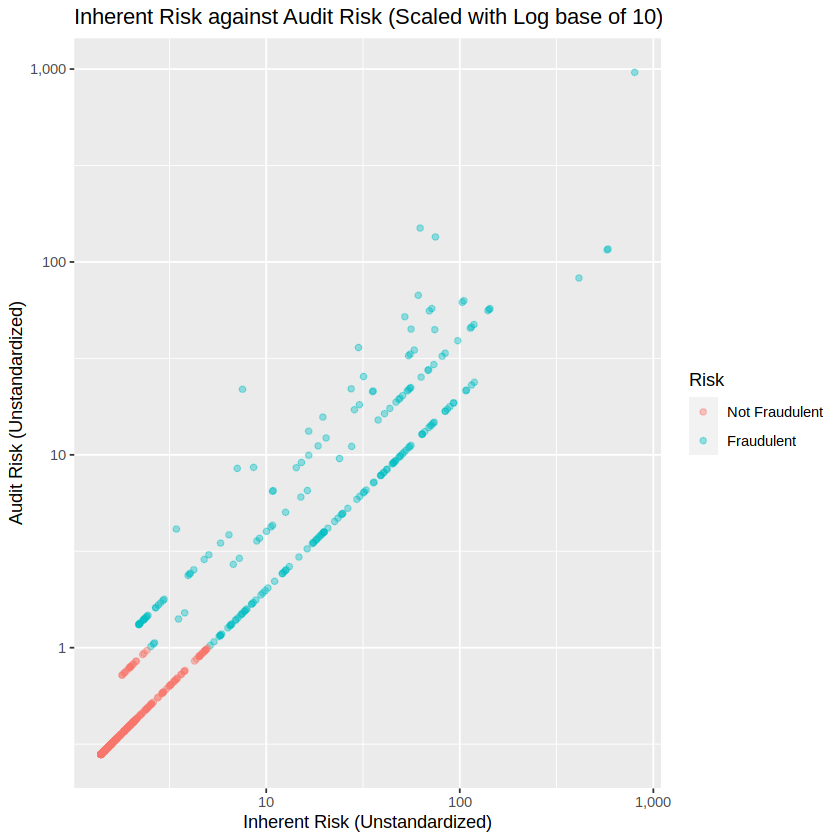

Warning message:
“Removed 66 rows containing missing values (`geom_point()`).”


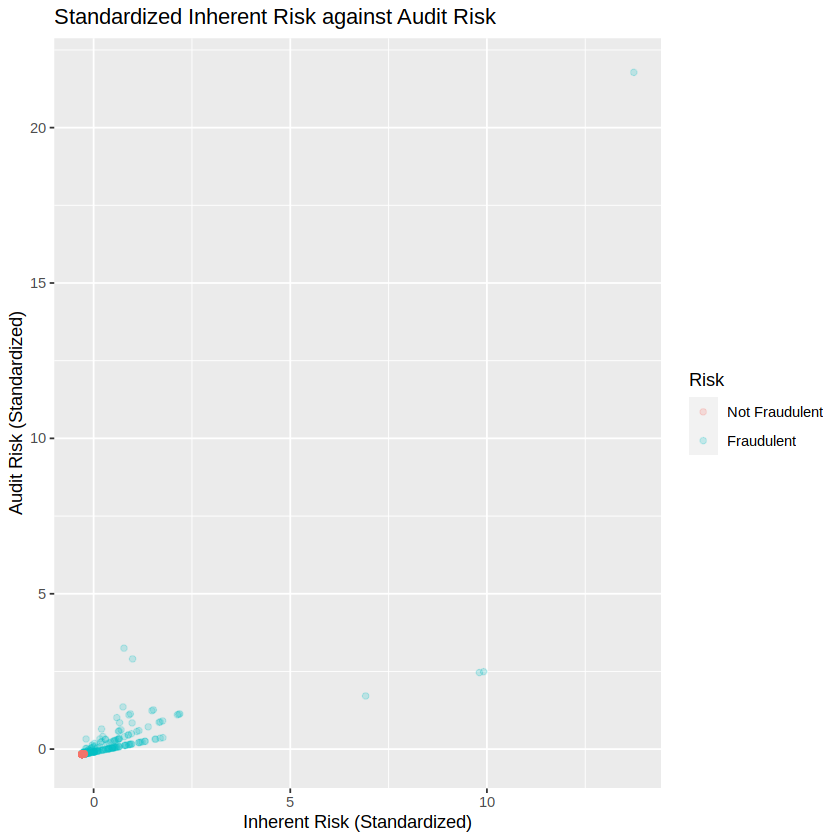

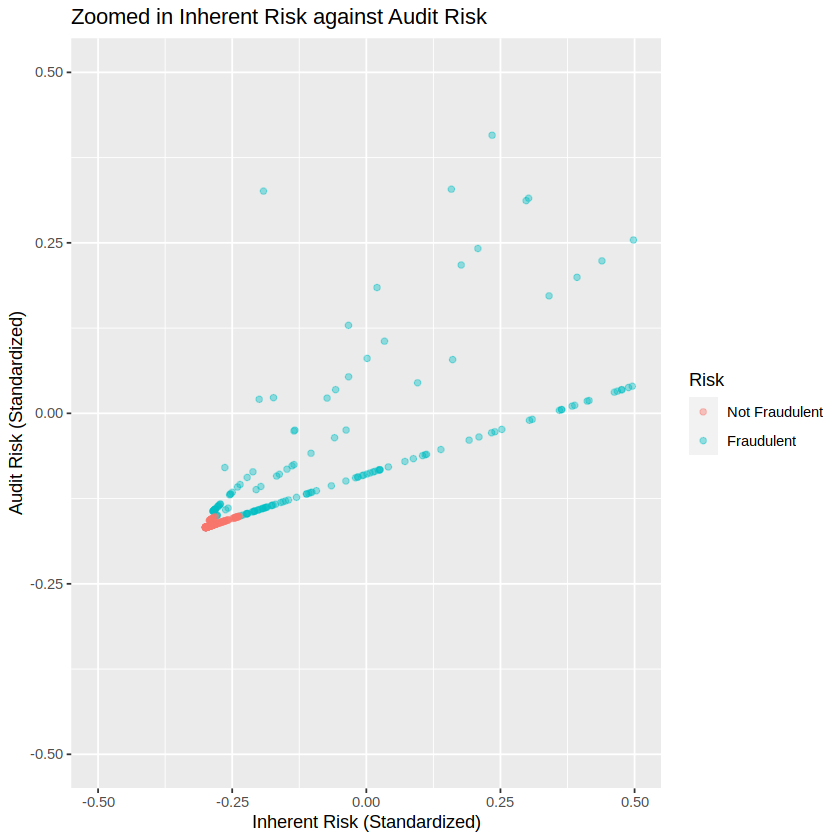

In [3]:
set.seed(888)

# Loads in the packages
library(tidyverse)
library(repr)
library(tidymodels)


# Loads the data into the variable
url <- "https://raw.githubusercontent.com/alexander-zhong/dsci-100-project/main/data/audit_risk.csv"
audit_risk_data <- read_csv(url) 

###############

# Clean up and turn the Risk variable into a factor for our classification
audit_risk_data <- audit_risk_data |>
    mutate(Risk = as_factor(Risk)) |>
    mutate(Risk = fct_recode(Risk, "Fraudulent" = "1", "Not Fraudulent" = "0"))
        

# splitting the data 
audit_risk_split <- initial_split(audit_risk_data, prop = .7, strata = Risk)
audit_risk_train <- training(audit_risk_split)
audit_risk_test <- testing(audit_risk_split)

##################

# see the total number of firms that are considered a risk or not a risk
preliminary_table1 <- audit_risk_train |>
    group_by(Risk) |>
    summarize(Count = n())
preliminary_table1


# see the average of our predictor variables
preliminary_table2 <- audit_risk_train |>
    select(CONTROL_RISK, Audit_Risk, Inherent_Risk) |>
    map_df(mean, na.rm = TRUE)

preliminary_table2


################## 
audit_recipe <- recipe(Risk ~ CONTROL_RISK + Audit_Risk + Inherent_Risk, data = audit_risk_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    prep()

audit_risk_train_scaled <- bake(audit_recipe, audit_risk_train)

audit_risk_train_scaled




preliminary_plot1 <- audit_risk_train |> 
    ggplot(aes(x = Inherent_Risk, y = Audit_Risk, color = Risk)) +
    geom_point(alpha = 0.4) + 
    labs(x = "Inherent Risk (Unstandardized)", y = "Audit Risk (Unstandardized)") +
    ggtitle("Inherent Risk against Audit Risk") +
    scale_x_log10(labels = label_comma()) +
    scale_y_log10(labels = label_comma()) + 
    ggtitle("Inherent Risk against Audit Risk (Scaled with Log base of 10)")
preliminary_plot1


preliminary_plot2 <- audit_risk_train_scaled |> 
    ggplot(aes(x = Inherent_Risk, y = Audit_Risk, color = Risk)) +
    geom_point(alpha = 0.2) + 
    labs(x = "Inherent Risk (Standardized)", y = "Audit Risk (Standardized)") +
    ggtitle("Standardized Inherent Risk against Audit Risk")
preliminary_plot2

preliminary_plot3 <- audit_risk_train_scaled |> 
    ggplot(aes(x = Inherent_Risk, y = Audit_Risk, color = Risk)) +
    geom_point(alpha = 0.4) + 
    labs(x = "Inherent Risk (Standardized)", y = "Audit Risk (Standardized)") +
    xlim(c(-0.5, 0.5)) +
    ylim(c(-0.5, 0.5)) +
    ggtitle("Zoomed in Inherent Risk against Audit Risk")
preliminary_plot3



## Methods
We will conduct our data analysis by setting 70% of the data as training data and 30% as testing data. We will only use three variables: Inherent Risk, Control Risk, and Audit risk to predict if a firm is classified as a risk. First, we need to scale/standardize these three variables. Then, we will plot six scatter plots in total using training data. Do cross-validation to find the most optimal K value. Finally, we will use testing data to test the accuracy of our prediction and gather some metrics such as precision, recall and accuracy.

One way we will visualize the results is by plotting a scatter plot with Inherent on the x-axis and Control Risk on the y-axis (as shown above). We also color the dots to indicate if the firm represented by each dot is classified as risk or not. Then, we can possibly create a plot of the predicted points on top of the training scatter plot and color the points that were wrongly predicted in red while the points that were predicted correctly in green. 

## Expected outcomes and significance

Throughout this project, we expect to find which predictors, and k values are best for our model when training and testing our classifier to identify fraudulent firms. Using the data, we can understand the relationship between risk factors and build a possibly reliable predictive model that has a balance of good accuracy, recall and precision. 

Our model that is built through this project could be a pioneer for future models that could be used by audit companies around the world to filter through firms faster. This would allow audit offices to develop early countermeasures.

Our model could also lead to future development in new risk factors that the data may not have accounted for.

Due to the fact that many people around the world still fall victim to fraudulent firms, our model could also act as a tool for the public to easily identify whether a firm is suspicious or not.

This leads us to ask, are there any predictors that could increase precision, recall, and accuracy at the same time? How can we make this tool more accessible to everyone?